# Covid X-Ray Diagnosis
## Machine Learning Final Project
### Enver Kapetanovic & Adrien Ventugol 
### Group 15

In [20]:
from os import listdir
from matplotlib import image
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
import pandas as pd 
import numpy as np
import sklearn
import imblearn

In [21]:
#converts RGB to Gray scale
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.144])

In [28]:
#Import images 
loaded_images = pd.DataFrame(columns=['File name','Data']+[str(i) for i in range(266)]+ ['Tested'])
counter = 0
for j in ['covid', 'non']:
    for filename in listdir('data_upload_v2/train/' + j):
        color_img = Image.open('data_upload_v2/train/'+ j +'/' + filename)
        color_img = color_img.resize((298, 237), Image.ANTIALIAS)
        gray_img = ImageOps.grayscale(color_img) 
        img_data = np.asarray(gray_img)
    # store loaded image
        if j == 'covid':
            loaded_images = loaded_images.append({'File name':"covid_"+ str(counter), 'Data':rgb2gray(img_data).astype(int), 'Tested':1},ignore_index=True)
        else:
            loaded_images = loaded_images.append({'File name':"non-covid_"+ str(counter), 'Data':rgb2gray(img_data).astype(int), 'Tested':0},ignore_index=True)
        counter+=1
    if j != "covid":   
        for foldername in listdir('data_upload_v2/test/' + j):
            for filename in listdir('data_upload_v2/test/' + j+'/'+foldername):
                color_img = Image.open('data_upload_v2/test/'+ j +'/' + foldername+'/'+filename)
                color_img = color_img.resize((298, 237), Image.ANTIALIAS)
                gray_img = ImageOps.grayscale(color_img) 
                img_data = np.asarray(gray_img)
            # store loaded image
                if j == 'covid':
                    loaded_images = loaded_images.append({'File name':"covid_"+ str(counter), 'Data':rgb2gray(img_data).astype(int), 'Tested':1},ignore_index=True)
                else:
                    loaded_images = loaded_images.append({'File name':"non-covid_"+ str(counter), 'Data':rgb2gray(img_data).astype(int), 'Tested':0},ignore_index=True)
                counter+=1
    else:
        for filename in listdir('data_upload_v2/test/' + j):
                color_img = Image.open('data_upload_v2/test/'+ j +'/'+filename)
                color_img = color_img.resize((298, 237), Image.ANTIALIAS)
                gray_img = ImageOps.grayscale(color_img) 
                img_data = np.asarray(gray_img)
            # store loaded image
                if j == 'covid':
                    loaded_images = loaded_images.append({'File name':"covid_"+ str(counter), 'Data':rgb2gray(img_data).astype(int), 'Tested':1},ignore_index=True)
                else:
                    loaded_images = loaded_images.append({'File name':"non-covid_"+ str(counter), 'Data':rgb2gray(img_data).astype(int), 'Tested':0},ignore_index=True)
                counter+=1


In [29]:
loaded_images = loaded_images.fillna(0)

#input the frequency of each pixel color into the dataframe
for j in range(loaded_images.shape[0]):
    counted = np.unique(loaded_images.loc[(0,'Data')],return_counts = True)
    pixel_shade = counted[0]
    index = 0
    frequency = counted[1]
    for i in pixel_shade:
        loaded_images.loc[(j,str(i))] = frequency[index]
        index+=1
loaded_images   


,File name,Data,0,1,2,3,4,5,6,7,...,257,258,259,260,261,262,263,264,265,Tested
0,covid_0,"[132, 104, 57, 20, 7, 2, 0, 2, 5, 6, 7, 6, 7, ...",1,0,2,0,0,1,4,7,...,0,0,0,0,0,0,0,0,0,1
1,covid_1,"[106, 104, 104, 108, 109, 112, 128, 148, 163, ...",1,0,2,0,0,1,4,7,...,0,0,0,0,0,0,0,0,0,1
2,covid_2,"[20, 21, 22, 23, 22, 23, 27, 82, 153, 141, 115...",1,0,2,0,0,1,4,7,...,0,0,0,0,0,0,0,0,0,1
3,covid_3,"[6, 6, 7, 7, 7, 8, 7, 7, 7, 6, 5, 5, 4, 3, 1, ...",1,0,2,0,0,1,4,7,...,0,0,0,0,0,0,0,0,0,1
4,covid_4,"[6, 7, 7, 8, 8, 8, 7, 7, 7, 7, 6, 6, 5, 5, 4, ...",1,0,2,0,0,1,4,7,...,0,0,0,0,0,0,0,0,0,1
5,covid_5,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,0,2,0,0,1,4,7,...,0,0,0,0,0,0,0,0,0,1
6,covid_6,"[126, 23, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...",1,0,2,0,0,1,4,7,...,0,0,0,0,0,0,0,0,0,1
7,covid_7,"[126, 129, 130, 132, 135, 136, 136, 136, 135, ...",1,0,2,0,0,1,4,7,...,0,0,0,0,0,0,0,0,0,1
8,covid_8,"[258, 231, 153, 160, 158, 157, 157, 156, 156, ...",1,0,2,0,0,1,4,7,...,0,0,0,0,0,0,0,0,0,1
9,covid_9,"[55, 66, 69, 74, 72, 93, 124, 126, 148, 147, 1...",1,0,2,0,0,1,4,7,...,0,0,0,0,0,0,0,0,0,1


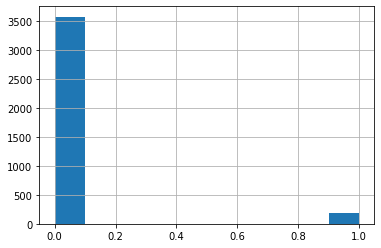

In [43]:
#Separate Data into X and y
y = loaded_images.loc[0:,'Tested']
X = loaded_images.loc[0:,'0':'255']
y.hist()

In [44]:
#Train test split
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X,y, train_size=.8, random_state=0)

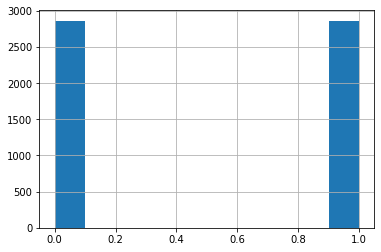

In [45]:
#Imbalanced Data, Solve with Random Over Sampling Technique
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=0)
X_train, y_train = ros.fit_resample(X_train, y_train)
y_train.hist()

In [18]:
from sklearn.naive_bayes import BernoulliNB

In [19]:
clf = BernoulliNB()
clf.fit(X_train, y_train)

BernoulliNB()